# Проект 10: "Анализ поведения пользователей мобильного приложения"

## Описание проекта

В стартапе по продаже продуктов питания через мобильное приложение необходимо разобраться, как ведут себя пользователи, изучить воронку продаж, определить основные этапы воронки и рассчитать основные метрики

Вторая часть задачи: проанализировать результаты A/A/B-эксперимента, в котором дизайнеры поменяли шрифты во всём приложении.

## <a id='oglav'>ОГЛАВЛЕНИЕ:</a>
[Шаг 1 - Загрузка данных](#paragraph1)
 - [Импорт библиотек](#lib_import)
 - [Загрузка файла с данными](#data_download)

[Шаг 2 - Подготовка данных](#paragraph2)
 - [2.1 Обработка названий столбцов](#col_names)
 - [2.2 Проверка типов данных](#dtype)
 - [2.3 Проверка пропусков в данных](#dropna)
 - [2.4 Добавление столбца с датой](#col_date)

[Шаг 3 - Изучение и проверка данных](#paragraph3)
 - [3.1 Расчёт данных в логе](#metrics)
 - [3.2 Определение периода сбора данных в логе](#period)
 - [3.3 Уточнённое число событий и пользователей](#metrics_upd)
 - [3.4 Проверка размеров экспериментальных групп](#exp_value)

[Шаг 4 - Изучение воронки продаж](#paragraph4)
 - [4.1 Изучение событий воронки](#41)
 - [4.2 Определение метрик событий воронки](#42)
 - [4.3 Определение последовательности событий воронки](#43)
 - [4.4 Определение конверсии воронки](#44conversion)
 - [4.5 Выявление наибольшего снижения конверсии](#45)
 - [4.6 Определение доли прошедших всю воронку пользователей](#46)

[Шаг 5 - Изучение результатов эксперимента](#paragraph5)
 - [5.1 Изучение экспериментальных групп](#51)
 - [5.2 Проверка результатов А/А-теста (группы 246 и 247)](#52)
 - [5.3 Проверка отличий групп А/А-теста по событиям на стат. достоверность](#53)
 - [5.4 Проверка отличий групп А/В-теста по событиям на стат. достоверность (А1/В, А2/В, (А1+А2)/В](#54)
 - [5.5 Определение уровня значимости при проверке стат. гипотез](#55)

[Шаг 6 - Выводы по проекту](#paragraph6)

## <a id='paragrapg1'>Шаг 1. Загрузка данных</a>
([К оглавлению](#oglav))

### <a id='lib_import'>Импорт библиотек</a>

In [1]:
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns


### <a id='data_download'>Загрузка файла с данными</a>

In [2]:
d = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
d.head(2)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


### Выводы по шагу 1
1. Бибилиотеки импортированы, данные загружены в датафрейм d

---

## <a id='paragrapg1'>Шаг 2. Подготовка данных</a>
([К оглавлению](#oglav))

**Шаг 2. Подготовьте данные**

1. Замените названия столбцов на удобные для вас;
- Проверьте пропуски и типы данных. Откорректируйте, если нужно;
- Добавьте столбец даты и времени, а также отдельный столбец дат;


---
### <a id='col_names'>2.1 Обработка названий столбцов</a>

In [3]:
d.head(2)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


In [4]:
d.columns = ['ev_name', 'uid', 'ev_dt', 'enum']
d.head(2)

,ev_name,uid,ev_dt,enum
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


---
### <a id='dtype'>2.2 Проверка типов данных</a>

In [5]:
d.info()

# Изменим формат даты-времени с unix на обычный
d['ev_dt'] = pd.to_datetime(d['ev_dt'],unit='s')
d.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
ev_name    244126 non-null object
uid        244126 non-null int64
ev_dt      244126 non-null int64
enum       244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,ev_name,uid,ev_dt,enum
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246


In [6]:
d.info() # всего строк 244126

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
ev_name    244126 non-null object
uid        244126 non-null int64
ev_dt      244126 non-null datetime64[ns]
enum       244126 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


### <a id='dropna'>2.3 Проверка пропусков и дубликатов в данных</a>

In [7]:
# Проверим, есть ли пропуски
d.isna().sum() # Пропусков нет

ev_name    0
uid        0
ev_dt      0
enum       0
dtype: int64

In [8]:
# Проверим, есть ли дубликаты
d[d[['ev_name','uid', 'ev_dt', 'enum']].duplicated() == True] # дубликаты есть !!!

,ev_name,uid,ev_dt,enum
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,247
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,247
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246


In [9]:
d[(d['uid']==434103746454591587)&(d['ev_dt'] == '2019-08-01 02:59:37')]

,ev_name,uid,ev_dt,enum
3572,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248


In [10]:
# Удалим дубликаты строк
d = d.drop_duplicates()
d[(d['uid']==434103746454591587)&(d['ev_dt'] == '2019-08-01 02:59:37')]

,ev_name,uid,ev_dt,enum
3572,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248


In [11]:
(1 - len(d) / 244126)*100 # удалили менее 0.2% строк

0.1691749342552562

---
### <a id='col_date'>2.3 Добавление столбца с датой</a>

In [12]:
d['ev_date'] =  d['ev_dt'].dt.date
d.head(3)

,ev_name,uid,ev_dt,enum,ev_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25


In [13]:
### ДОПОЛНИТЕЛЬНО ###

### Добавим столбец с временем
d['ev_time'] =  d['ev_dt'].dt.round('min')
d.head(3)

,ev_name,uid,ev_dt,enum,ev_date,ev_time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,2019-07-25 04:44:00
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,2019-07-25 11:12:00
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,2019-07-25 11:29:00


### Выводы по шагу 2
1. Переименованы названия столбцов
- Изменён формат даты
- Пропуски не выявлены. Дубликаты удалены
- Добавлен столбец с датой события (без указания времени)

---

## <a id='paragraph3'>Шаг 3. Изучение и проверка данных</a>
([К оглавлению](#oglav))

[Шаг 3 - Изучение и проверка данных](#paragraph3)
 - [3.1 Расчёт данных в логе](#metrics)
 - [3.2 Определение периода сбора данных в логе](#period)
 - [3.3 Уточненные число событий и пользователей](#metrics_upd)
 - [3.4 Проверка размеров экспериментальных групп](#exp_value)

---
### <a id='metrics'>3.1 Расчёт данных в логе</a>

1. Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?

In [14]:
# Определим число событий в логе
len(d)

243713

In [15]:
# Определим число уникальных пользователей
d['uid'].nunique()

7551

In [16]:
# Определим, сколько в среднем событий приходится на пользователя
d.groupby('uid').agg({'enum':'count'}).agg({'enum':['mean', 'median']}).T

,mean,median
enum,32.275593,20.0


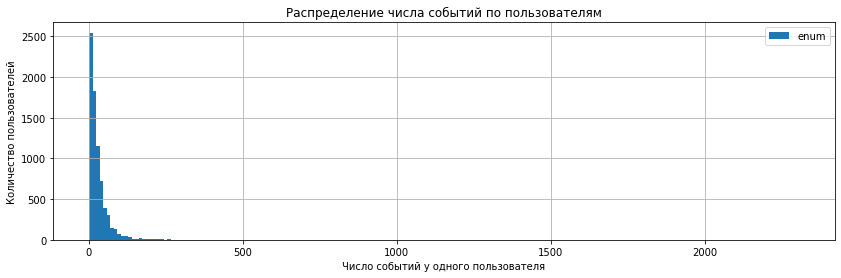

In [17]:
# Для наглядности построим кривую распределения
d.groupby('uid').agg({'enum':'count'}).plot.hist(bins=200, grid=True, figsize=(14,4),
                                                title='Распределение числа событий по пользователям')
plt.xlabel('Число событий у одного пользователя')
plt.ylabel('Количество пользователей');

#### Вывод по задаче 3.1
1. Всего в логе 243 713 событий
- Всего в логе 7551 уникальных пользователей
- В среднем на одного пользователя приходится около 20 событий, но данные очень неоднородные, далеки от нормального распределения.

---
### <a id='period'>3.2 Определение периода сбора данных в логе</a>

1. Данными за какой период вы располагаете? 
- Найдите максимальную и минимальную дату. 
- Постройте гистограмму по дате и времени. 
- Можно ли быть уверенным, что у вас одинаково полные данные за весь период? 
- Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». 
- Определите, с какого момента данные полные и отбросьте более старые. 
- Данными за какой период времени вы располагаете на самом деле?

In [18]:
# Посмотрим на даты по всем событиям
d.agg({'ev_date':['min', 'max']}).T

,min,max
ev_date,2019-07-25,2019-08-07


In [19]:
d['ev_date'].max() - d['ev_date'].min() 

datetime.timedelta(days=13)

In [20]:
# Всего даты в логе
d['ev_date'].nunique()

14

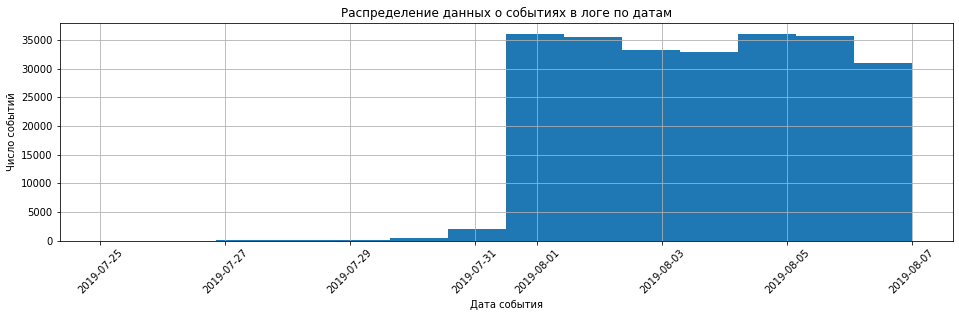

In [21]:
d['ev_date'].hist(figsize=(16,4), bins=d['ev_date'].nunique())
plt.xticks(rotation=45)
plt.title('Распределение данных о событиях в логе по датам')
plt.xlabel('Дата события'); plt.ylabel('Число событий');

Из графика выше видно, что данные в период с 25.07 по 31.07 являются неполными.

In [22]:
# Сравним число событий в день из разных периодов
d[d['ev_date'] == pd.to_datetime('2019-07-27')]['enum'].count() # 55
d[d['ev_date'] == pd.to_datetime('2019-08-03')]['enum'].count() # 33282

33282

Очевидно, что число событий в разные периоды несопоставимы между собой.

--> Для анализа возьмём только данные, начиная с 2019-08-01 (остальное удалим)

In [23]:
dl = d.loc[d['ev_date'] >= pd.to_datetime('2019-08-01')].copy()
dl.agg({'ev_date':['min','max']}).T

,min,max
ev_date,2019-08-01,2019-08-07


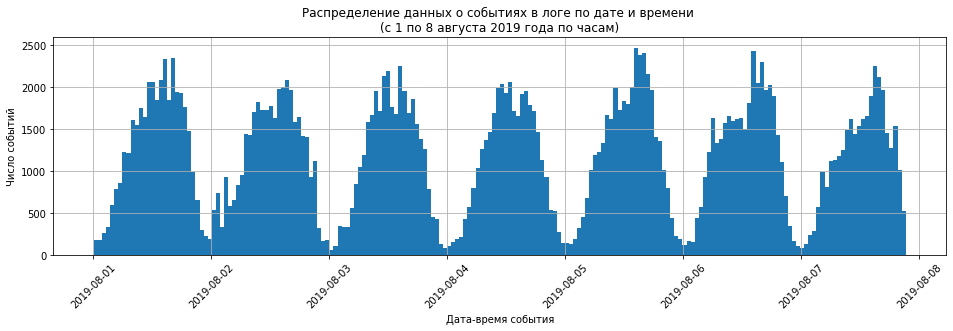

In [24]:
dl['ev_time'].hist(figsize=(16,4), bins=200)
plt.xticks(rotation=45)
plt.title('Распределение данных о событиях в логе по дате и времени \n(с 1 по 8 августа 2019 года по часам)')
plt.xlabel('Дата-время события'); plt.ylabel('Число событий');

---
### <a id='metrics_upd'>3.3 Уточнённое число событий и пользователей</a>

Посмотрим, насколько изменились метрики после изменения исходных данных

In [25]:
# Сравним число уникальных пользователей
d['uid'].nunique() # 7551
dl['uid'].nunique() # 7534
(1 - dl['uid'].nunique() / d['uid'].nunique())*100 # Потери в уникальных пользователях - около 0.22%
d['uid'].nunique() - dl['uid'].nunique() # всего 17 пользователей

17

In [26]:
# Сравним число событий
len(d) # 243713
len(dl) # 240887
(1 - len(dl)/len(d))*100 # число событий уменьшилось на 1.15%
len(d)-len(dl) # или на 2826 штук

2826

---
### <a id='exp_value'>3.4 Проверка размеров экспериментальных групп</a>

Проверим наличие информации о событиях пользователей всех трёх экспериментальных групп.

In [27]:
dl.groupby('enum')['uid'].nunique().to_frame()

,uid
enum,
246,2484
247,2513
248,2537


### Выводы по шагу 3
1. В исходном логе представлены данные за период с 27 июля по 8 августа 2019 года.
- Детальное изучение данных показало, что число данных в период до 1 августа многократне меньше, чем то же число в период после 1 августа.
- Для дальнейшего анализа возьмём период с 01-08-2019 по 08-08-2019, при этом потери составят всего 0.22% уникальных пользователей или 1.15% от общего числа событий
- В измененном датасете содержится информация о примерно равном числе пользователей по экспериментальным группам.

---

## <a id='paragraph4'>Шаг 4. Изучение воронки продаж</a>
([К оглавлению](#oglav))

[Шаг 4 - Изучение воронки продаж](#paragraph4)
 - [4.1 Изучение событий воронки](#41)
 - [4.2 Определение метрик событий воронки](#42)
 - [4.3 Определение последовательности событий воронки](#43)
 - [4.4 Определение конверсии воронки](#44conversion)
 - [4.5 Выявление наибольшего снижения конверсии](#45)
 - [4.6 Определение доли прошедших всх воронку пользователей](#46)

---
### <a id='41'>4.1 Изучение событий воронки</a>

Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [28]:
dl['ev_name'].value_counts().to_frame()

,ev_name
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [30]:
events = pd.DataFrame({'ev_name':['MainScreenAppear','OffersScreenAppear',
                         'CartScreenAppear','PaymentScreenSuccessful','Tutorial'],
             'ev_nameRu':['Главный экран','Страница заказа','Карточка товаров',
                          'Успешная оплата','Инструкция'],
             })
events

,ev_name,ev_nameRu
0,MainScreenAppear,Главный экран
1,OffersScreenAppear,Страница заказа
2,CartScreenAppear,Карточка товаров
3,PaymentScreenSuccessful,Успешная оплата
4,Tutorial,Инструкция


---
### <a id='42'>4.2 Определение метрик событий воронки</a>

Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [31]:
# Посчитаем число пользователей, совершивших каждое из событий
steps_users = dl.groupby('ev_name').agg({'uid':'nunique'}).sort_values(by='uid', ascending=False)
display(steps_users)
print('Число уникальных пользователей, которые совершали каждое из событий')

,uid
ev_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Число уникальных пользователей, которые совершали каждое из событий


In [32]:
# Посчитаем долю пользователей, которые хотя бы раз совершали каждое из событий
uni_us_tot = dl['uid'].nunique() # всего уникальных пользователей в логе 7534
steps_users['part_of_tot'] = steps_users['uid'] / uni_us_tot
display(steps_users)
print('Доля пользователей, которые хотя бы раз совершали каждое из событий')

,uid,part_of_tot
ev_name,,
MainScreenAppear,7419,0.984736
OffersScreenAppear,4593,0.609636
CartScreenAppear,3734,0.495620
PaymentScreenSuccessful,3539,0.469737
Tutorial,840,0.111495


Доля пользователей, которые хотя бы раз совершали каждое из событий


---
### <a id='43'>4.3 Определение последовательности событий воронки</a>

Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

In [33]:
events

,ev_name,ev_nameRu
0,MainScreenAppear,Главный экран
1,OffersScreenAppear,Страница заказа
2,CartScreenAppear,Карточка товаров
3,PaymentScreenSuccessful,Успешная оплата
4,Tutorial,Инструкция


Предполагаю, что последовательность событий в цепочке такая:
1. Главный экран
2. Страница заказа
3. Карточка товара
4. Успешная оплата.

Дополнительные действия: 
 * Инструкция

не является обязательным, поэтому в цепочку не включён.

---
### <a id='44conversion'>4.4 Определение конверсии воронки</a>

По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [34]:
# Обозначим этапы цепочки
steps_users['chain'] = [1,1,1,1,0]
chain_steps = steps_users[steps_users['chain']==1]
chain_steps

,uid,part_of_tot,chain
ev_name,,,
MainScreenAppear,7419,0.984736,1
OffersScreenAppear,4593,0.609636,1
CartScreenAppear,3734,0.495620,1
PaymentScreenSuccessful,3539,0.469737,1


In [36]:
# Определим конверсию к предыдущему шагу
conv=[1]
for i in range(0,3):
    result = chain_steps['uid'][i+1] / chain_steps['uid'][i]
    conv.append(result)
conv
chain_steps['conv_to_prev'] = conv
chain_steps.sort_values(by='uid', ascending=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,uid,part_of_tot,chain,conv_to_prev
ev_name,,,,
MainScreenAppear,7419,0.984736,1,1.000000
OffersScreenAppear,4593,0.609636,1,0.619086
CartScreenAppear,3734,0.495620,1,0.812976
PaymentScreenSuccessful,3539,0.469737,1,0.947777


---
### <a id='45'>4.5 Выявление наибольшего снижения конверсии</a>

На каком шаге теряете больше всего пользователей?

In [37]:
chain_steps

,uid,part_of_tot,chain,conv_to_prev
ev_name,,,,
MainScreenAppear,7419,0.984736,1,1.000000
OffersScreenAppear,4593,0.609636,1,0.619086
CartScreenAppear,3734,0.495620,1,0.812976
PaymentScreenSuccessful,3539,0.469737,1,0.947777


Самая низкая консверсия к предыдущему шагу наблюдается на шаге "Cтраница заказа" - около 62%.

---
### <a id='46'>4.6 Определение доли прошедших всю воронку пользователей</a>

Какая доля пользователей доходит от первого события до оплаты?

In [38]:
# Доля пользователей, которые проходят всю воронку, у нас уже посчитана в таблице steps_users
steps_users[steps_users.index == 'PaymentScreenSuccessful'][['part_of_tot']]

,part_of_tot
ev_name,
PaymentScreenSuccessful,0.469737


Доля пользователей, которые проходят всю воронку, составляет около 47%.

### Выводы по шагу 4
1. Определили события, которые составляют цепочку воронки: Главный экран -> Страница заказа -> Карточка товара -> Успешная оплата.
- Ещё одно событие в логе - Инструкция - является дополнительным событиям, не входят в цепочку основных событий воронки (конверсию по ним не считаем).
- Для информации: раздел Инструкция открывают около 11% всех пользователей.
- Самая низкая конверсия воронки наблюдается на событии "Страница заказа", составляет менее 62%.
- Процент пользователей, прошедших всю воронку, составляет около 47%.

---

## <a id='paragraph5'>Шаг 5. Изучение результатов эксперимента</a>
([К оглавлению](#oglav))

[Шаг 5 - Изучение результатов эксперимента](#paragraph5)
 - [5.1 Изучение экспериментальных групп](#51)
 - [5.2 Проверка результатов А/А-теста (группы 246 и 247)](#52)
 - [5.3 Проверка отличий групп А/А-теста по событиям на стат. достоверность](#53)
 - [5.4 Проверка отличий групп А/В-теста по событиям на стат. достоверность (А1/В, А2/В, (А1+А2)/В](#54)
 - [5.5 Определение уровня значимости при проверке стат. гипотез](#55)

---
### <a id='51'>5.1 Изучение экспериментальных групп</a>

Сколько пользователей в каждой экспериментальной группе?

In [39]:
dl

,ev_name,uid,ev_dt,enum,ev_date,ev_time
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,2019-08-01 00:07:00
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,2019-08-01 00:08:00
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,2019-08-01 00:09:00
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,2019-08-01 00:09:00
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,2019-08-01 00:09:00
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,2019-08-07 21:12:00
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,2019-08-07 21:14:00
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,2019-08-07 21:15:00
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,2019-08-07 21:15:00


In [40]:
# Число событий в каждой экспериментальной группе 
dl['enum'].value_counts().reset_index().sort_values(by='index')

,index,enum
1,246,79302
2,247,77022
0,248,84563


In [41]:
# Число пользователей в каждой экспериментальной группе
dl.groupby('enum').agg({'uid':'nunique'})

,uid
enum,
246,2484
247,2513
248,2537


---
### <a id='52'>5.2 Проверка результатов А/А-теста (группы 246 и 247)</a>

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

In [42]:
# Выделим отдельно экспериментальные группы А/А-теста
ex246 = dl[dl['enum']==246]
ex247 = dl[dl['enum']==247]
display(ex246.head(3), ex247.head(3))

,ev_name,uid,ev_dt,enum,ev_date,ev_time
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,2019-08-01 00:07:00
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,2019-08-01 00:08:00
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,2019-08-01 00:09:00


,ev_name,uid,ev_dt,enum,ev_date,ev_time
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,2019-08-01 00:09:00
2833,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01,2019-08-01 00:10:00
2838,MainScreenAppear,4899590676214355127,2019-08-01 00:11:28,247,2019-08-01,2019-08-01 00:11:00


In [43]:
ex246_chain = ex246.groupby('ev_name').agg({'uid':'nunique'}).drop(['Tutorial'], axis=0)
ex247_chain = ex247.groupby('ev_name').agg({'uid':'nunique'}).drop(['Tutorial'], axis=0)

In [44]:
ex246_chain = ex246_chain.sort_values(by='uid', ascending=False)
ex247_chain = ex247_chain.sort_values(by='uid', ascending=False)

In [45]:
def conv(df):
    '''
    Создаёт новый столбец с конверсией к предыдущему шагу
    '''
    conv=[1]
    for i in range(0,3):
        result = df['uid'][i+1]/df['uid'][i]
        conv.append(result)
    df['conv_to_prev'] = conv
    display(df)

In [46]:
conv(ex246_chain)
conv(ex247_chain)

,uid,conv_to_prev
ev_name,,
MainScreenAppear,2450,1.000000
OffersScreenAppear,1542,0.629388
CartScreenAppear,1266,0.821012
PaymentScreenSuccessful,1200,0.947867


,uid,conv_to_prev
ev_name,,
MainScreenAppear,2476,1.000000
OffersScreenAppear,1520,0.613893
CartScreenAppear,1238,0.814474
PaymentScreenSuccessful,1158,0.935380


In [47]:
uniq246 = ex246['uid'].nunique()
uniq247 = ex247['uid'].nunique()
display(uniq246, uniq247)

2484

2513

!!! ПОМЕТКА:
 * Цифры немного странные, т.к. получается, что часть пользователей (2484-2450) и (2513-2476) в группах не посетили главную страницу, но при этом посетили или карточку товара или страницу "обучение".

In [48]:
ex246_chain[['conv_to_prev']]

,conv_to_prev
ev_name,
MainScreenAppear,1.000000
OffersScreenAppear,0.629388
CartScreenAppear,0.821012
PaymentScreenSuccessful,0.947867


In [49]:
# Проверим разницу между выборками 246 и 247 на статистическую значимость

# Установим критический уровень статистической значимости 1%
alpha = .01
# Проверим гипотезу о равенстве долей
successes = np.array([2450, 2476])
trials = np.array([2484, 2513])
# Пропорция успехов в группе 246 и 247
p246 = successes[0]/trials[0]
p247 = successes[1]/trials[1]
# Пропорция успехов в комбинированным датасете
p_comb = (successes[0]+successes[1])/(trials[0]+trials[1])
# Разница пропорция в датасетах экспериментов
diff = p246-p247
#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = diff/mt.sqrt(p_comb*(1-p_comb)*(1/trials[0] + 1/trials[1]))
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value, ', alpha =', alpha)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.7570597232046099 , alpha = 0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Из проверки стат. значимости отличий долей в группах 246 и 247 можно сделать вывод, что разница не имеет статистической значимость, т.е. **по событию MainScreenAppear группы разделены корректно**!

---
### <a id='53'>5.3 Проверка отличий групп А/А-теста по событиям на стат. достоверность</a>

* Выберите самое популярное событие. 
* Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. 
* Посчитайте долю пользователей, совершивших это событие. 
* Проверьте, будет ли отличие между группами статистически достоверным. 
* Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). 
* Можно ли сказать, что разбиение на группы работает корректно?

**Выберем самое популярное событие**

In [50]:
# Определим самое популярное событие в группе 246
ex246_chain[ex246_chain['uid'] == ex246_chain['uid'].max()] # Это Открыл главный экран

,uid,conv_to_prev
ev_name,,
MainScreenAppear,2450,1.0


In [51]:
# Определим самое популярное событие во всём логе
dl.groupby('ev_name').agg({'uid':'nunique'}).sort_values(by='uid', ascending=False).head(1)
# Это событие - также "Открыл главный экран"

,uid
ev_name,
MainScreenAppear,7419


**Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп**

In [52]:
# Соберём таблицу с основными метриками
t=(dl.pivot_table(index='ev_name', 
                columns='enum', 
                values='uid', 
                aggfunc='nunique')
# .loc['MainScreenAppear',:]
# .to_frame()
  ).T
t

ev_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
enum,,,,,
246,1266,2450,1542,1200,278
247,1238,2476,1520,1158,283
248,1230,2493,1531,1181,279


In [53]:
# Число уникальных пользователей по группам
uniq248 = dl[dl['enum']==248]['uid'].nunique()
print('''
В группе 246 - {} уникальных пользователей,
В группе 247 - {} уникальных пользователей,
В группе 248 - {} уникальных пользователей
'''.format(uniq246, uniq247, uniq248))


В группе 246 - 2484 уникальных пользователей,
В группе 247 - 2513 уникальных пользователей,
В группе 248 - 2537 уникальных пользователей



In [54]:
t['uniq_u_group'] = [uniq246,uniq247,uniq248]
if 'Tutorial' in t.columns:
    t=t.drop(['Tutorial'], axis=1)
else:
    pass
t=t[['uniq_u_group','MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]
t.columns = ['uniq_u_group', 'Main_u', 'Offer_u', 'Cart_u', 'Payment_u']
t

,uniq_u_group,Main_u,Offer_u,Cart_u,Payment_u
enum,,,,,
246,2484,2450,1542,1266,1200
247,2513,2476,1520,1238,1158
248,2537,2493,1531,1230,1181


In [55]:
# Добавим информацию о конверсии по событиям
t['conv_M_O'] = t['Offer_u']/ t['Main_u']
t['conv_O_C'] = t['Cart_u']/ t['Offer_u']
t['conv_C_P'] = t['Payment_u']/ t['Cart_u']
# Добавим информацию о долях к общему чилу пользователей в группе
t['Main_part'] = t['Main_u'] / t['uniq_u_group']
t['Offer_part'] = t['Offer_u'] / t['uniq_u_group']
t['Cart_part'] = t['Cart_u'] / t['uniq_u_group']
t['Payment_part'] = t['Payment_u'] / t['uniq_u_group']
# Перегруппируем колонки для удобства
t = t[['uniq_u_group', 'Main_u', 'Main_part', 
       'Offer_u', 'Offer_part', 'conv_M_O', 
       'Cart_u', 'Offer_part', 'conv_O_C',
       'Payment_u', 'Payment_part', 'conv_C_P']]
t

,uniq_u_group,Main_u,Main_part,Offer_u,Offer_part,conv_M_O,Cart_u,Offer_part,conv_O_C,Payment_u,Payment_part,conv_C_P
enum,,,,,,,,,,,,
246,2484,2450,0.986312,1542,0.620773,0.629388,1266,0.620773,0.821012,1200,0.483092,0.947867
247,2513,2476,0.985277,1520,0.604855,0.613893,1238,0.604855,0.814474,1158,0.460804,0.935380
248,2537,2493,0.982657,1531,0.603469,0.614120,1230,0.603469,0.803396,1181,0.465510,0.960163


In [56]:
# Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп
t[['Main_u']]

,Main_u
enum,
246,2450
247,2476
248,2493


**Посчитаем долю пользователей, совершивших это событие**

In [57]:
# Посчитаем долю пользователей, совершивших это событие, во всём логе
dl[dl['ev_name'] == 'MainScreenAppear']['uid'].nunique() / uni_us_tot # 98.47%

0.9847358640828245

**Проверим, будет ли отличие между группами статистически достоверным, по событию MainScreenAppear**

In [58]:
t

,uniq_u_group,Main_u,Main_part,Offer_u,Offer_part,conv_M_O,Cart_u,Offer_part,conv_O_C,Payment_u,Payment_part,conv_C_P
enum,,,,,,,,,,,,
246,2484,2450,0.986312,1542,0.620773,0.629388,1266,0.620773,0.821012,1200,0.483092,0.947867
247,2513,2476,0.985277,1520,0.604855,0.613893,1238,0.604855,0.814474,1158,0.460804,0.935380
248,2537,2493,0.982657,1531,0.603469,0.614120,1230,0.603469,0.803396,1181,0.465510,0.960163


In [59]:
#Проверим, будет ли отличие между группами статистически достоверным
alpha = .01

# Используем тест для проверки равенства долей для события MainScreenAppear
# Проверим гипотезу о равенстве долей
successes = np.array([t['Main_u'][246], t['Main_u'][247]])
trials = np.array([t['uniq_u_group'][246], t['uniq_u_group'][247]])
# Пропорция успехов в группе 246 и 247
p246 = successes[0]/trials[0]
p247 = successes[1]/trials[1]
# Пропорция успехов в комбинированным датасете
p_comb = (successes[0]+successes[1])/(trials[0]+trials[1])
# Разница пропорция в датасетах экспериментов
diff = p246-p247
#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = diff/mt.sqrt(p_comb*(1-p_comb)*(1/trials[0] + 1/trials[1]))
#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение для события Main_u: ', p_value, ', alpha =',alpha)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение для события Main_u:  0.7570597232046099 , alpha = 0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты проверка показывают, что различия между группами по событию "Открыл главных экран" статистически недостоверны, т.е. считаем их одинаковыми

In [60]:
# Проделаем то же самое для всех других событий (в виде функции)
def stat_check_for_event(event_col, g1, g2):
    successes = np.array([t[event_col][g1], t[event_col][g2]])
    trials = np.array([t['uniq_u_group'][g1], t['uniq_u_group'][g2]])
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_comb = (successes[0]+successes[1])/(trials[0]+trials[1])
    diff = p1-p2
    z_value = diff/mt.sqrt(p_comb*(1-p_comb)*(1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print(f'Для события {event_col} p-значение: {p_value}, alpha={alpha}')
    if (p_value < alpha):
        print("!!! Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

In [61]:
stat_check_for_event('Offer_u', 246, 247)

Для события Offer_u p-значение: 0.2480954578522181, alpha=0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [62]:
stat_check_for_event('Cart_u', 246, 247)

Для события Cart_u p-значение: 0.22883372237997213, alpha=0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [63]:
stat_check_for_event('Payment_u', 246, 247)

Для события Payment_u p-значение: 0.11456679313141849, alpha=0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты проверок показывают, что различия для каждого события между группами 246 и 247 не являются статистически значимыми. 

Вывод: **разделение на группы осуществляется корректно!**

---
### <a id='54'>5.4 Проверка отличий групп А/В-теста по событиям на стат. достоверность (А1/В, А2/В, (А1+А2)/В</a>

Аналогично поступите с группой с изменённым шрифтом. 
* Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. 
* Сравните результаты с объединённой контрольной группой. 
* Какие выводы из эксперимента можно сделать?

In [64]:
for i in ['Main_u', 'Offer_u', 'Cart_u', 'Payment_u']:
    stat_check_for_event(i, 246, 248)
    print()

Для события Main_u p-значение: 0.2949721933554552, alpha=0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Offer_u p-значение: 0.20836205402738917, alpha=0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Cart_u p-значение: 0.07842923237520116, alpha=0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Payment_u p-значение: 0.2122553275697796, alpha=0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [65]:
for i in ['Main_u', 'Offer_u', 'Cart_u', 'Payment_u']:
    stat_check_for_event(i, 247, 248)
    print()

Для события Main_u p-значение: 0.4587053616621515, alpha=0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Offer_u p-значение: 0.9197817830592261, alpha=0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Cart_u p-значение: 0.5786197879539783, alpha=0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Payment_u p-значение: 0.7373415053803964, alpha=0.01
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вручную сравним с объединенной контрольной группой**

In [66]:
alpha=.01
for i in ['Main_u', 'Offer_u', 'Cart_u', 'Payment_u']:
    successes = np.array([t[i][246]+t[i][247], t[i][248]])
    trials = np.array([t['uniq_u_group'][246]+t['uniq_u_group'][247], t['uniq_u_group'][248]])
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_comb = (successes[0]+successes[1])/(trials[0]+trials[1])
    diff = p1-p2
    z_value = diff/mt.sqrt(p_comb*(1-p_comb)*(1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print(f'Для события {i} p-значение: {p_value}')
    if (p_value < alpha):
        print("!!! Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
    print()

Для события Main_u p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Offer_u p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Cart_u p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Payment_u p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Выводы из задачи 5.4**
1. Проведенный эксперимент показывает, что изменение шрифта в мобильном приложении никак не влияет на покупателей с точки зрения изменених их поведения. Изменения есть, но статистической значимости они не имеют. Поэтому изменение шрифтов в приложении внудрять нецелесообразно.

In [67]:
### ДОПОЛНИТЕЛЬНО

# Добавим строку с дельтой между основными метриками теста 248 и 247
if '248-247' in t.index:
    pass
else:
    t = t.append(pd.Series([2537-2513,2493-2476,'',
                            1531-1520,'','',1230-1238,'','',
                            1181-1158,'',''], index=t.columns, 
                           name='248-247'), ignore_index=False)
t

,uniq_u_group,Main_u,Main_part,Offer_u,Offer_part,conv_M_O,Cart_u,Offer_part,conv_O_C,Payment_u,Payment_part,conv_C_P
enum,,,,,,,,,,,,
246,2484,2450,0.986312,1542,0.620773,0.629388,1266,0.620773,0.821012,1200,0.483092,0.947867
247,2513,2476,0.985277,1520,0.604855,0.613893,1238,0.604855,0.814474,1158,0.460804,0.93538
248,2537,2493,0.982657,1531,0.603469,0.61412,1230,0.603469,0.803396,1181,0.46551,0.960163
248-247,24,17,,11,,,-8,,,23,,


Из абсолютных значений видно, что разница в значениях очень невелика, что подтверждает выводы из задачи 5.4

---
### <a id='55'>5.5 Определение уровня значимости при проверке стат. гипотез</a>

* Какой уровень значимости вы выбрали при проверке статистических гипотез выше? 
* Посчитайте, сколько проверок статистических гипотез вы сделали. 
* При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. 
* Какой уровень значимости стоит применить? 
* Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

Ответы на вопросы:

1. Для проверки статистических гипотез был выбран критический уровень статистической значимости в 1% (alpha=.01).
- Всего было проведено 17 проверок статистических гипотез.
- Исходя из того, что при alpha=0.01 каждый десятый раз можно получать ложный результат, достоверность проверки гипотез составила не менее (17 * (1 - 0.01)) / 17 * 100 = 99.0% (что примерно равно критическому уровню стат.значимости)
- Оптимальный, на мой взгляд, уроверь стат. значимости составляет в данном случае 1% (alpha=0.01).

In [68]:
for i in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    print(f'При alpha={i}, достоверность результатов составит {(17*(1-i))/17*100:.1f}%')

При alpha=0.001, достоверность результатов составит 99.9%
При alpha=0.005, достоверность результатов составит 99.5%
При alpha=0.01, достоверность результатов составит 99.0%
При alpha=0.05, достоверность результатов составит 95.0%
При alpha=0.1, достоверность результатов составит 90.0%
При alpha=0.2, достоверность результатов составит 80.0%


In [69]:
# Проведём допольнительно проверку стат. гипотез с разным alpha

for alpha in [0.001, 0.05, 0.1, 0.2]:
    for event in ['Main_u', 'Offer_u', 'Cart_u', 'Payment_u']:
        stat_check_for_event(event, 246, 248)
        print()

Для события Main_u p-значение: 0.2949721933554552, alpha=0.001
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Offer_u p-значение: 0.20836205402738917, alpha=0.001
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Cart_u p-значение: 0.07842923237520116, alpha=0.001
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Payment_u p-значение: 0.2122553275697796, alpha=0.001
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Main_u p-значение: 0.2949721933554552, alpha=0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Offer_u p-значение: 0.20836205402738917, alpha=0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Cart_u p-значение: 0.07842923237520116, alpha=0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [68]:
for alpha in [0.001, 0.05, 0.1, 0.2]:
    for event in ['Main_u', 'Offer_u', 'Cart_u', 'Payment_u']:
        stat_check_for_event(event, 247, 248)
        print()

Для события Main_u p-значение: 0.4587053616621515, alpha=0.001
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Offer_u p-значение: 0.9197817830592261, alpha=0.001
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Cart_u p-значение: 0.5786197879539783, alpha=0.001
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Payment_u p-значение: 0.7373415053803964, alpha=0.001
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Main_u p-значение: 0.4587053616621515, alpha=0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Offer_u p-значение: 0.9197817830592261, alpha=0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для события Cart_u p-значение: 0.5786197879539783, alpha=0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Для 

### Выводы по шагу 5
1. Проверка А/А-теста на стат. значимость различий показала, что разделение на группы происходит корректно, никакой статистически значимой разницы между метриками групп 246 и 247 не выявлено.
- Проверка А/В-теста на стат. значимость различий показала, что изменение шрифтов в мобильном приложении значимо не повлияла на пользовательское поведение и на конверсию. Следовательно, внедрять изменения нецелесообразно.
- Оптимальный уровень статистической значимости в данном случае рекомендуется уровень в 1% (alpha=0.01).

---

## <a id='paragraph6'>Шаг 6. Выводы по проекту</a>
([К оглавлению](#oglav))

**Подробные выводы по всем шагам**:
1. В исходном логе представлены данные за период с 27 июля по 8 августа 2019 года.
- Детальное изучение данных показало, что число данных в период до 1 августа многократне меньше, чем то же число в период после 1 августа.
- Для дальнейшего анализа возьмём период с 01-08-2019 по 08-08-2019, при этом потери составят всего 0.22% уникальных пользователей или 1.15% от общего числа событий
- В измененном датасете содержится информация о примерно равном числе пользователей по экспериментальным группам.

1. Определили события, которые составляют цепочку воронки: Главный экран -> Страница заказа -> Карточка товара -> Успешная оплата.
- Ещё одно событие в логе - Инструкция - является дополнительным событиям, не входят в цепочку основных событий воронки (конверсию по ним не считаем).
- Для информации: раздел Инструкция открывают около 11% всех пользователей.
- Самая низкая конверсия воронки наблюдается на событии "Страница заказа", составляет менее 62%.
- Процент пользователей, прошедших всю воронку, составляет около 47%.

1. Проверка А/А-теста на стат. значимость различий показала, что разделение на группы происходит корректно, никакой статистически значимой разницы между метриками групп 246 и 247 не выявлено.
- Проверка А/В-теста на стат. значимость различий показала, что изменение шрифтов в мобильном приложении значимо не повлияла на пользовательское поведение и на конверсию. Следовательно, внедрять изменения нецелесообразно.
- Оптимальный уровень статистической значимости в данном случае рекомендуется уровень в 1% (alpha=0.01).

### Общие выводы по проекту

<b>
    1. Изменение шрифта в приложении никак не скажется на покупательской активности пользователей.
    - Самая низкая конверсия наблюдается при переходе с главного экрана на экран заказов (около 62%).
</b>

Рекомендации:
1. Доработать главный экран мобильного приложения для увеличения конверсии на этапе перехода на Страницу заказов.
- Разработать другие гипотезы для увеличения продаж (кроме изменения шрифтов в приложении) и провести тесты для изучения их влияния на покупательскую активность пользователей.